<div style="background-color: #ffffff ; padding: 10px;">

**Goal**: Chart entry/exit points for the last year, based on 7-day and 90-day SMAs.

**Data:** [CVS_2023_data.csv](./CVS_2023_data.csv) (Google Finance)

**Skills**: statistical analysis, financial analysis, data visualization

**Technology**: Python, Pandas, Numpy, Holoviews

**Result**: [combined_signals_plot.png](./combined_signals_plot.png)
</div>

In [7]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
from holoviews import opts

import warnings
warnings.filterwarnings("ignore")

In [8]:
# create df from the CSV
cvs_df = pd.read_csv(
    Path("CVS_2023_data.csv"), 
    index_col="Date", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
cvs_df

,Close
Date,
2022-01-03 16:00:00,145.07
2022-01-04 16:00:00,144.42
2022-01-05 16:00:00,137.65
2022-01-06 16:00:00,137.55
2022-01-07 16:00:00,137.00
...,...
2023-12-22 16:00:00,142.72
2023-12-26 16:00:00,142.82
2023-12-27 16:00:00,141.44


In [9]:
# use the pct_change function to generate returns from close prices
cvs_df["Actual Returns"] = cvs_df["Close"].pct_change()

# Set the short window and long window
short_window = 7
long_window = 90

# Generate the fast and slow simple moving averages (SMAs)
cvs_df["7-day SMA"] = cvs_df["Close"].rolling(window=short_window).mean()
cvs_df["90-day SMA"] = cvs_df["Close"].rolling(window=long_window).mean()

# signals (just changes - not entry/exit)
# create signal column and default value (bool)
cvs_df["Signal"] = 0.0

# 1 = SMA_Fast > SMA_Slow
# 0 = SMA_Slow < SMA_Fast
# the colon after short window means all the windows; go through all the rows
cvs_df["Signal"][short_window:] = np.where(
    # condition, result, else
    cvs_df["7-day SMA"][short_window:] > cvs_df["90-day SMA"][short_window:], 1.0, 0.0
)

# entry/exits
# new column that shows when signal CHANGES VALUE to signify when a stock should be bought or sold
cvs_df["Entry/Exit"] = cvs_df["Signal"].diff()

# Filter df for 2023 data
cvs_df = cvs_df[(cvs_df.index >= "2023-01-01") & (cvs_df.index <= "2023-12-31")]

cvs_df

,Close,Actual Returns,7-day SMA,90-day SMA,Signal,Entry/Exit
Date,,,,,,
2023-01-03 16:00:00,89.70,0.010932,88.548571,98.298778,0.0,0.0
2023-01-04 16:00:00,88.71,-0.011037,88.612857,97.976667,0.0,0.0
2023-01-05 16:00:00,86.77,-0.021869,88.178571,97.704111,0.0,0.0
2023-01-06 16:00:00,88.16,0.016019,88.211429,97.457667,0.0,0.0
2023-01-09 16:00:00,88.80,0.007260,88.545714,97.223111,0.0,0.0
...,...,...,...,...,...,...
2023-12-22 16:00:00,142.72,0.006488,138.072857,134.874556,1.0,0.0
2023-12-26 16:00:00,142.82,0.000701,139.447143,135.011889,1.0,0.0
2023-12-27 16:00:00,141.44,-0.009663,140.532857,135.160000,1.0,0.0


In [10]:
# create and overlay plots

# plot closing prices
close_plot = cvs_df["Close"].hvplot(
    color="gray",
    legend=True,
    width=1200,
    height=500,
    ylabel="USD",
    xlabel="date (2023)",
    title="CVS Entry/Exit Points (2023)",
).opts(
    xticks=12
)

# plot SMAs
sma_plot = cvs_df[["7-day SMA", "90-day SMA"]].hvplot(
    color=["#6495ED", "goldenrod"],
    legend=True,
    width=1200,
    height=500
)

# plot entry points
entry = cvs_df[cvs_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color="mediumseagreen",
    marker="^",
    width=1200,
    height=500,
    legend=False
)

# plot exit points
exit = cvs_df[cvs_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color="crimson",
    marker="v",
    width=1200,
    height=500,
    legend=False
)

# combine plots
combined_signals_plot = close_plot * sma_plot * entry * exit

# save as html and save as png directly - Gecko driver issues
hvplot.save(combined_signals_plot, "combined_signals_plot.html")

combined_signals_plot

:Overlay
   .Curve.Close      :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

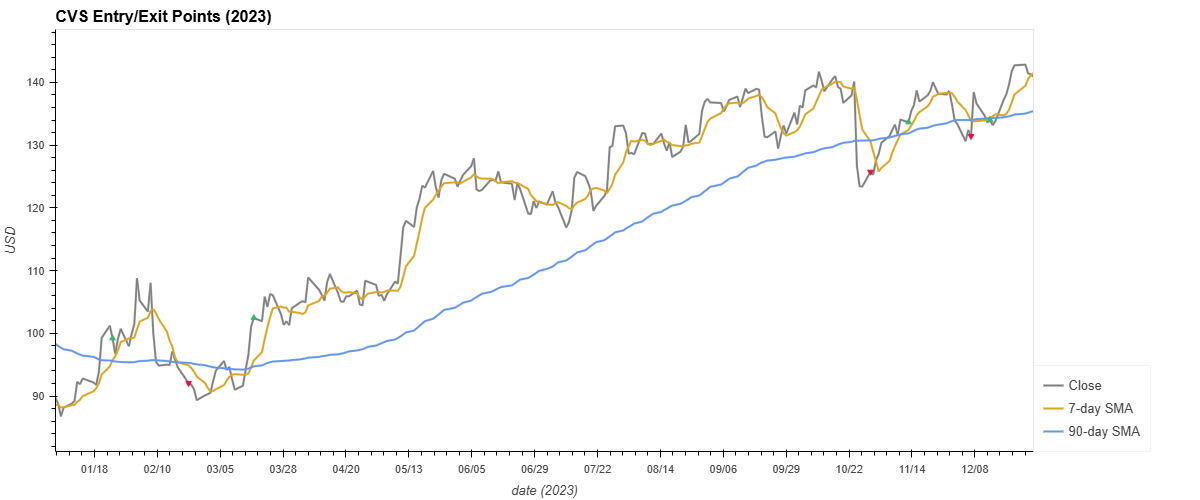